# Predicting housing prices using regression


# Index

- [Abstract](#Abstract)
- [1. Introduction](#1.-Introduction)
- [2. The Data](#2.-The-Data)
    - [2.1 Import the Data](#2.1-Import-the-Data)
    - [2.2 Data Exploration](#2.2-Data-Exploration)
    - [2.3 Data Preparation](#2.3-Data-Preparation)
    - [2.4 Correlation](#2.4-Correlation)
- [3. Project Description](#3.-Project-Description)
    - [3.1 Linear Regression](#3.1-Linear-Regression)
    - [3.2 Analysis](#3.2-Analysis)
    - [3.3 Results](#3.3-Results)
    - [3.4 Verify Your Model Against Test Data](#3.4-Verify-Your-Model-Against-Test-Data)
- [Conclusion](#Conclusion)
- [References](#References)

[Back to top](#Index)


##  Abstract

In this project we applied multiple linear regression on a housing price dataset to predict house sale prices from a number of variables. We tested 6 different models, using 7, 14, or 20 numeric variables as predictors and using either sale price or the logarithm of sale price as the target. The models were fitted on 100 data points and tested on 100 new data points. Out of the 6 models, the best-fitting one (when tested on new data) was the model with 20 variables that used the logarithm of sale price as the target. The goodness of fit in this case was $R^2 = 0.843$. The log transformation did improve the fit; using a strictly linear model with 20 variables yielded a lower  $R^2 = 0.732$. As expected, using fewer (7 or 14) independent variables yielded less good fits. 

[Back to top](#Index)


## 1. Introduction

In this project we are using linear regression to predict house sale prices from a number of variables about houses, based on a large public dataset. We first explore the data by plotting the histogram of the target (dependent variable) `SalePrice`, which turns out to be highly skewed and can be improved by a log transformation. We then explore some of the variables that may be good candidates for our prediction (based on a priori knowledge about houses, such as square footage) and plot their scatterplots against `SalePrice`. 

Our next aim is to compute the Pearson's correlation coefficient between each numeric variable and the `SalePrice` (or `log(SalePrice)`) target and order them from highest correlated to lowest correlated. Prior to that, we need to drop all the columns that contain non-numeric variables, drop columns that contain mostly null values, and perform linear interpolation on the columns that are only missing a few values. Once we obtain the sorted correlation values for each of the remaining 40 columns, we find that approximately 20 columns have medium to high correlation with sale price ($R >= 0.30$). 

We then decide to test the linear model with 3 possible sets of independent variables (of length 7, 14, and 20 respectively) and with 2 possible targets: `SalePrice` or `log(SalePrice)`.

We go over these steps in detail below. All the code is provided.

[Back to top](#Index)

## 2. The Data

The data for this project is from the Ames housing dataset, which is publicly available on Kaggle (see References). The data contains 82 variables, or columns, corresponding to different features of a house and its context. 

We worked with two subsets of the full dataset, with a sample of 100 data points (houses) as the training dataset (`houseSmallData.csv`) and another sample of 100 points as the testing dataset (`jtest.csv`). Below we import the data and the necessary Python modules and then start exploring the data.

[Back to top](#Index)

### 2.1 Import the Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the Scikit-Learn linear_model module
from sklearn import linear_model

# Import the training dataset as a Pandas DataFrame
houseSmallData = pd.read_csv('houseSmallData.csv') 

# Import the testing dataset as a Pandas DataFrame
jtest = pd.read_csv('jtest.csv') 

# See data_description.txt for details about each variable.

[Back to top](#Index)

### 2.2 Data Exploration

First, we check the shape (or dimensions) of the `houseSmallData` dataframe and display its first 5 rows.

In [2]:
print(houseSmallData.shape)
houseSmallData.head()

(100, 82)


,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


This data set has 100 rows and 82 columns, each corresponding to a different feature of a house (such as square footage, year sold, etc.). We note that there are some non-numeric values and also some missing values (NaN). 

A first question to ask is, is the target data (`SalePrice`) approximately normally distributed? To verify, we plot its histogram and compute its skew below.



1.1783462304851948

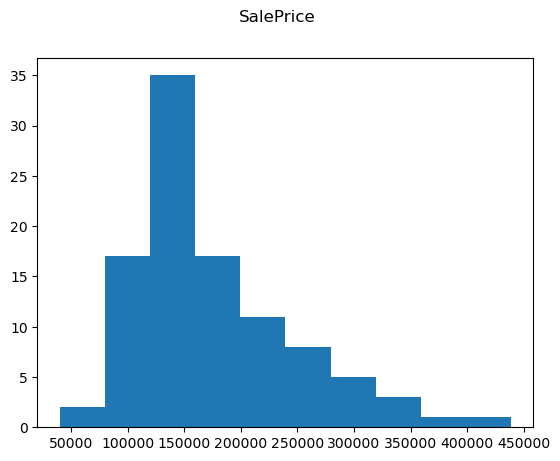

In [3]:
# Plotting histogram of SalePrice
plt.hist(houseSmallData['SalePrice'])
plt.suptitle('SalePrice')
# Computing skew
houseSmallData['SalePrice'].skew()


The high skew value (1.178) and the above histogram indicate that the `SalePrice` data is _**not**_ normally distributed, but may be log-normal. To verify, next we plot the skew and histogram for `log(SalePrice)`.

-0.09632240207755555

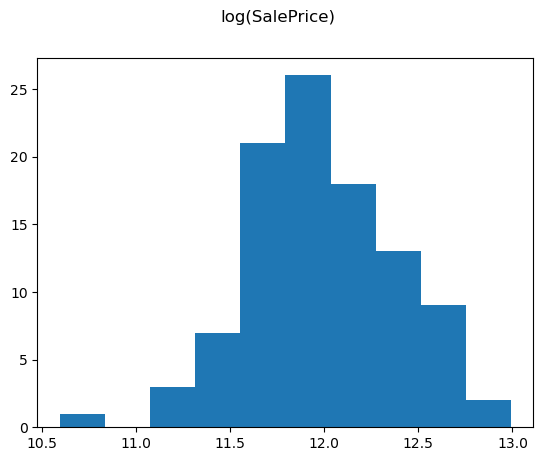

In [4]:
# Plotting histogram of log(SalePrice)
plt.hist(np.log(houseSmallData['SalePrice']))
plt.suptitle('log(SalePrice)')
# Computing skew
np.log(houseSmallData['SalePrice']).skew()

The above histogram indicates that `log(SalePrice)` is approximately normally distributed&mdash;at least more so than `SalePrice`. The skew is much closer to 0 (-0.0963). Therefore we will consider `log(SalePrice)` a possible target for our model. In other words, we will consider fitting a **log-linear model**, beyond the linear model based on `SalePrice`.

We will now further explore the data by plotting some numeric variables that may be good candidates for our linear regression (based on a priori knowledge about houses): `GrLivArea` (above grade living area square footage), 
`LotArea` (lot area), `1stFlrSF` (first floor square footage). We show below the scatterplots of each of these variables against `SalePrice`. (The code is also provided for plots against `log(SalePrice`), commented out for the sake of keeping the document lean, but the main results are written out for those tests as well).


Text(0.8, 0.8, 'R=0.74')

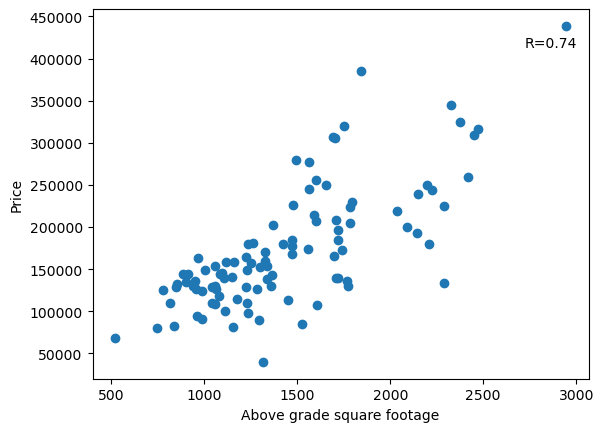

In [5]:
# Extracting SalePrice (the dependent variable of interest) and 
# GrLivArea (a single independent variable, a priori of interest
# in prediciting SalePrice) as single columns from houseSmallData
X = houseSmallData['GrLivArea']
Y = houseSmallData['SalePrice']
# Y = np.log(houseSmallData['SalePrice'])

# Plotting scatterplot of SalePrice as a function of GrLivArea
plt.scatter(X,Y)
plt.xlabel('Above grade square footage')
plt.ylabel('Price')
# Calculating the Pearson's correlation coefficient between X and Y and showing it on the graph (rounded to 2 decimals)
corr = X.corr(Y)
plt.figtext(0.8,0.8,f'R={corr:.2f}')

The above scatterplot indicates that the `GrLivArea` variable (which is the above grade living area square footage) has a correlation $R$ of 0.74 with the `SalePrice` variable which indicates that it is probably a good independent variable to predict sale price and may be a good candidate to include in our regression model. Of note, using `log(SalePrice)` instead of `SalePrice` slightly lowers $R$ to 0.70 (figure not shown).

Text(0.8, 0.8, 'R=0.50')

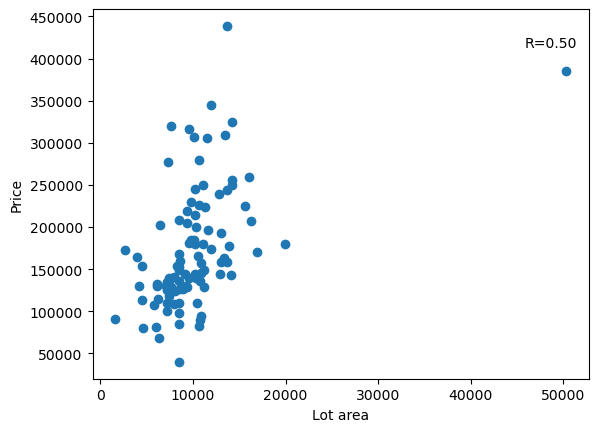

In [6]:
# Now extracting LotArea
X = houseSmallData['LotArea']
Y = houseSmallData['SalePrice']

# Showing scatterplot of SalePrice as a function of LotArea
plt.scatter(X,Y)
plt.xlabel('Lot area')
plt.ylabel('Price')
# Calculating the Pearson's correlation coefficient between X and Y and showing it on the graph (rounded to 2 decimals)
corr = X.corr(Y)
plt.figtext(0.8,0.8,f'R={corr:.2f}')

In the above graph for `LotArea`, there seems to be an outlier data point with a much higher value (`LotArea` of approximately 50,000) than all other data points (which are all below 20,000). Therefore the `LotArea` variable seems like not a great choice for modeling.

Text(0.8, 0.8, 'R=0.55')

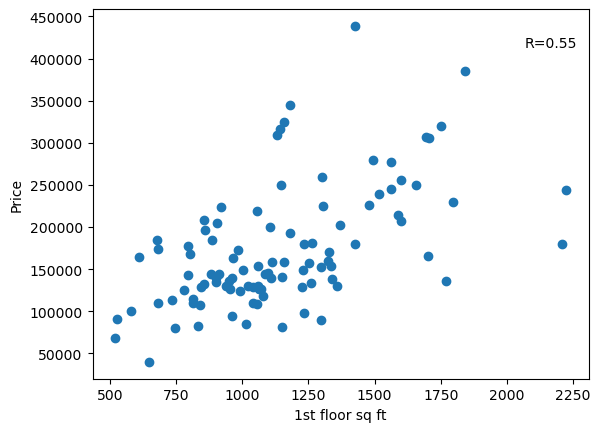

In [7]:
# Now extracting 1stFlrSF
X = houseSmallData['1stFlrSF']
Y = houseSmallData['SalePrice']
#Y = np.log(houseSmallData['SalePrice'])

# Showing scatterplot of SalePrice as a function of 1stFlrSF
plt.scatter(X,Y)
plt.xlabel('1st floor sq ft')
plt.ylabel('Price')
# Calculating the Pearson's correlation coefficient between X and Y and showing it on the graph (rounded to 2 decimals)
corr = X.corr(Y)
plt.figtext(0.8,0.8,f'R={corr:.2f}')


The above graph shows the correlation between sale price and the 1st floor surface area. It shows a medium size correlation (Pearson's correlation coefficient of 0.55) and therefore this independent variable may be a good one to include in our regression model. Of note, using `log(SalePrice)` instead of `SalePrice` barely changes $R$ (from 0.55 to 0.57, figure not shown).

[Back to top](#Index)

### 2.3 Data Preparation

First, since we are using a linear regression model, we need all variables to be numeric (and not of type `String` or other object). Since the `houseSmallData` DataFrame contains many columns that are not of a numeric type, we are going to remove them. We use the function `.select_dtypes()` to select only the columns for which the data type is a `number`. We call this new DataFrame `houseSmallDataNumeric`.


In [8]:
# Creating a new DataFrame of the data, keeping only the columns of a numeric type:
houseSmallDataNumeric = houseSmallData.select_dtypes(include=[np.number])
houseSmallDataNumeric.head(10)

,Unnamed: 0,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,...,61,0,0,0,0,NaN,0,2,2008,208500
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,...,0,0,0,0,0,NaN,0,5,2007,181500
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,...,42,0,0,0,0,NaN,0,9,2008,223500
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,...,35,272,0,0,0,NaN,0,2,2006,140000
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,...,84,0,0,0,0,NaN,0,12,2008,250000
5,5,6,50,85.0,14115,5,5,1993,1995,0.0,...,30,0,320,0,0,NaN,700,10,2009,143000
6,6,7,20,75.0,10084,8,5,2004,2005,186.0,...,57,0,0,0,0,NaN,0,8,2007,307000
7,7,8,60,NaN,10382,7,6,1973,1973,240.0,...,204,228,0,0,0,NaN,350,11,2009,200000
8,8,9,50,51.0,6120,7,5,1931,1950,0.0,...,0,205,0,0,0,NaN,0,4,2008,129900
9,9,10,190,50.0,7420,5,6,1939,1950,0.0,...,4,0,0,0,0,NaN,0,1,2008,118000


We find that there are 40 columns (out of 82 total) that are of a numeric type. As explained above, we only keep those. 

Next, we find which columns contain null (or missing, or NaN) values in the data. Columns that have a lot of missing data would not work well for building our regression model and we will consider dropping them. 


In [9]:
# Finding which columns contain null values in the data (sorting by decreasing number of null values):
nulls = pd.DataFrame(houseSmallDataNumeric.isnull().sum().sort_values(ascending=False)[0:5])
nulls

,0
PoolQC,100
LotFrontage,14
GarageYrBlt,6
Unnamed: 0,0
OpenPorchSF,0


Note: For the sake of readability, we only showed the first 5 indices (after sorting by decreasing number of null values) because it appears that only 3 columns (`PoolQC`, `LotFrontage`, and `GarageYrBlt`) contain some null values; the rest of the (numeric) columns do not contain any null values.

In addition, we see that the column `PoolQC` contains 100 nulls. In other words, all 100 entries in the database have a null value for this column. Therefore we are going to drop it since it will not be helpful for our regression.

As for the columns `LotFrontage` and `GarageYrBlt`, since they are only missing a few datapoints, we are not going to drop them but use **linear interpolation** to fill in the missing data in these 2 columns.

In [10]:
# Dropping column 'PoolQC' from the houseSmallDataNumeric DataFrame,
# with 
#      axis=1 to indicate dropping a column (and not a row)
#      inplace=True to make the change permanent in houseSmallDataNumeric
houseSmallDataNumeric.drop('PoolQC',axis=1,inplace=True)

In [11]:
# Checking that one column was deleted by displaying the new shape of the houseSmallDataNumeric DataFrame
houseSmallDataNumeric.shape

(100, 39)

In [12]:
# Linear interpolation of missing data 
# using inplace=True to make the change permanent in houseSmallDataNumeric
houseSmallDataNumeric.interpolate(axis=1,inplace=True)

We noted above that it would be good to **log-transform** the `SalePrice` data. Therefore we are now adding a new column, `logSalePrice`, which will be equal to `log(SalePrice)`, as another possible target for our linear regression model.

In [13]:
# Add a column with log(SalePrice); it will be used to test if log-transformation improves model fits
houseSmallDataNumeric["logSalePrice"]=np.log(houseSmallDataNumeric["SalePrice"])
houseSmallDataNumeric.head()

,Unnamed: 0,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,logSalePrice
0,0.0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,...,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,12.247694
1,1.0,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,12.109011
2,2.0,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,...,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,12.317167
3,3.0,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,...,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,11.849398
4,4.0,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,...,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,12.429216


[Back to top](#Index)

### 2.4 Correlation



Now that we completed the cleaning and interpolation steps, we are going to compute correlations between the columns using the function `.corr()` which yields a correlation matrix. Of note, we are only interested in the correlation between `SalePrice` (or `logSalePrice`) and each of the other variables; we are not interested in every possible cross-correlation between variables. Therefore we only need to look at the last 2 columns in the DataFrame `correlation_matrix = houseSmallDataNumeric.corr()`, which correspond to `SalePrice` and `logSalePrice`, respectively.

In [14]:
correlation_matrix = houseSmallDataNumeric.corr()
correlation_matrix[['SalePrice','logSalePrice']]

,SalePrice,logSalePrice
Unnamed: 0,-0.162735,-0.156502
Id,-0.162735,-0.156502
MSSubClass,-0.066819,-0.088061
LotFrontage,-0.042694,0.021698
LotArea,0.497124,0.453226
OverallQual,0.855061,0.843360
OverallCond,-0.170443,-0.091355
YearBuilt,0.658636,0.698622
YearRemodAdd,0.548330,0.587051
MasVnrArea,0.571836,0.532881


We find that there is quite a range of correlation values. To help us see how the variables compare to each other in terms of their correlation to `SalePrice` or `logSalePrice` (i.e. their ability to predict `SalePrice` or `logSalePrice`), below we sort these correlations values in decreasing order (in absolute value) so that the most strongly correlated variables are on top. 

In [15]:
#indiv_correlations = correlation_matrix['SalePrice']
indiv_correlations = correlation_matrix['logSalePrice']
sorted_indiv_correlations = indiv_correlations.abs().sort_values(ascending=False)
sorted_indiv_correlations

logSalePrice     1.000000
SalePrice        0.959746
OverallQual      0.843360
GrLivArea        0.700019
YearBuilt        0.698622
GarageArea       0.685404
GarageCars       0.658574
TotalBsmtSF      0.639880
YearRemodAdd     0.587051
FullBath         0.569660
1stFlrSF         0.567244
MasVnrArea       0.532881
TotRmsAbvGrd     0.518780
Fireplaces       0.498968
LotArea          0.453226
WoodDeckSF       0.413828
HalfBath         0.344438
OpenPorchSF      0.339115
2ndFlrSF         0.334656
BsmtFinSF1       0.306323
BsmtUnfSF        0.300776
EnclosedPorch    0.288212
GarageYrBlt      0.276476
BedroomAbvGr     0.276200
KitchenAbvGr     0.251936
YrSold           0.230045
MoSold           0.211134
LowQualFinSF     0.180357
BsmtFullBath     0.173979
Unnamed: 0       0.156502
Id               0.156502
MiscVal          0.119349
BsmtFinSF2       0.114525
OverallCond      0.091355
MSSubClass       0.088061
ScreenPorch      0.069942
LotFrontage      0.021698
BsmtHalfBath     0.009409
3SsnPorch   

We find that there are approximately 20 variables with a correlation $R$ that is 0.3 or greater, i.e. moderate or strong. We will therefore consider including up to 20 independent variables in the model.


[Back to top](#Index)

## 3. Fitting several models

In this section, we implement 6 different versions of a linear regression model in Python using the Scikit-Learn package. We describe our choice of the 6 models, with numbers of independent variables ranging from 7 to 14 to 20, and explain how these specific variables were chosen out of the 40 available numeric variables. We implement the option of using a log-transformation (with `log(SalePrice)` as the target) and report how this log-linear version of the model yields better results than the strictly linear version. Our best model overall, a 20-variable log-linear model, yielded $R^2 = 0.882$ when tested on the training data, and $R^2 = 0.843$ when tested on new data. These performance scores are higher than those reported by Dr. Williams with 5 independent variables (which were $R^2 = 0.83$ on the training data and $R^2 = 0.74$ on the new data).


[Back to top](#Index)

### 3.1 Linear Regression

The algorithm we are using is multiple linear regression (of type "ordinary least squares" or OLS). This algorithm fits a linear model with coefficients $w = (w_1, …, w_p)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear model.

In this Python project we are using the class `sklearn.linear_model.LinearRegression` from the Scikit-Learn package (see References). To quantify goodness-of-fit, we use the `.score()` method (from the `LinearRegression` class) which returns the coefficient of determination of the prediction, $R^2$ (R-squared).

[Back to top](#Index)

### 3.2 Analysis: summary

Here we are running 3 different versions of the model: `model20`, `model14`, and `model7`, in either a strictly linear form (using `SalePrice` as the target) or in log-linear form (using `logSalePrice` as the target).

- `model20` is using the top 20 variables most correlated  to `SalePrice`: `OverallQual`, `GrLivArea`, `GarageArea`, `GarageCars`, `YearBuilt`, `TotalBsmtSF`, `FullBath`, `MasVnrArea`, `TotRmsAbvGrd`, `1stFlrSF`, `YearRemodAdd`, `Fireplaces`, `WoodDeckSF`, `2ndFlrSF`, `BsmtUnfSF`, `HalfBath`, `OpenPorchSF`, `BsmtFinSF1`, `YrSold`, `MoSold` (skipping `LotArea` which contains outlier data, as we saw during the exploration phase).

- `model14` is using the top 14 most correlated variables: `OverallQual`, `GrLivArea`, `GarageArea`, `GarageCars`, `YearBuilt`, `TotalBsmtSF`, `FullBath`, `MasVnrArea`, `TotRmsAbvGrd`, `1stFlrSF`, `YearRemodAdd`, `Fireplaces`, `WoodDeckSF`, `2ndFlrSF` (also skipping `LotArea`).

- `model7` is using 7 handpicked variables that, on face value, may be more independent from each other and therefore may have more predictive value when combined. (This is merely an educated guess based on a priori knowledge about houses.) These 7 variables, which are a subset of the above sets, are: `OverallQual`, `GrLivArea`, `GarageArea`, `YearBuilt`, `FullBath`, `MasVnrArea`, `TotRmsAbvGrd`.

**To summarize, for comparison purposes we are running 6 different model fits, using the 3 different sets of independent variables listed above, with either `SalePrice` or `logSalePrice` as a target.**



R-squared between true sale price data and model7 predictions (testing on the training data): 0.829
R-squared between true sale price data and model14 predictions (testing on the training data): 0.873
R-squared between true sale price data and model20 predictions (testing on the training data): 0.882


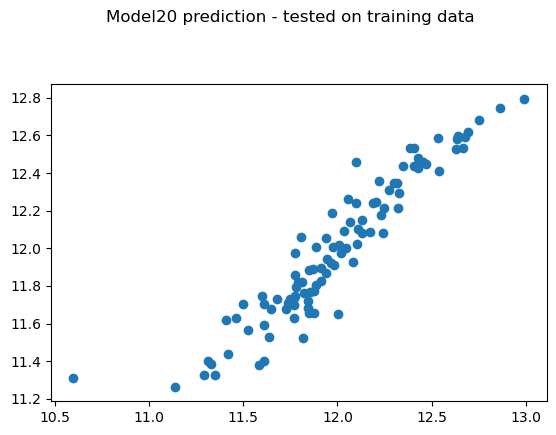

In [16]:
# Performing the linear regression model fits

# Initializing the 3 models
lr7 = linear_model.LinearRegression()
lr14 = linear_model.LinearRegression()
lr20 = linear_model.LinearRegression()

# For model7, using 7 handpicked independent variables:
X7 = houseSmallDataNumeric[['OverallQual', 'GrLivArea', 'GarageArea','YearBuilt','FullBath','MasVnrArea','TotRmsAbvGrd']]

# For model14, using the top 14 independent variables (determined earlier from the correlation analysis):
X14 = houseSmallDataNumeric[['OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars',
       'YearBuilt', 'TotalBsmtSF', 'FullBath', 'MasVnrArea',
       'TotRmsAbvGrd', '1stFlrSF', 'YearRemodAdd', 'Fireplaces',
       'WoodDeckSF','2ndFlrSF']]

# For model20, using the top 20 independent variables (determined earlier from the correlation analysis):
X20 = houseSmallDataNumeric[['OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars',
       'YearBuilt', 'TotalBsmtSF', 'FullBath', 'MasVnrArea',
       'TotRmsAbvGrd', '1stFlrSF', 'YearRemodAdd', 'Fireplaces',
       'WoodDeckSF','2ndFlrSF','BsmtUnfSF', 'HalfBath', 'OpenPorchSF', 'BsmtFinSF1',
       'YrSold', 'MoSold']]

# Target: SalePrice or log(SalePrice)
#Y = houseSmallDataNumeric['SalePrice']
Y = houseSmallDataNumeric['logSalePrice']

# Model fits for the 3 different models
model7 = lr7.fit(X7, Y)
model14 = lr14.fit(X14, Y)
model20 = lr20.fit(X20, Y)

# Note: Here test data is the same as training data. In section 3.4 we test the models on new data.
print(f'R-squared between true sale price data and model7 predictions (testing on the training data): {model7.score(X7,Y):.3f}')
print(f'R-squared between true sale price data and model14 predictions (testing on the training data): {model14.score(X14,Y):.3f}')
print(f'R-squared between true sale price data and model20 predictions (testing on the training data): {model20.score(X20,Y):.3f}')

# Scatter plot of predictions (for model20):
fig, axs = plt.subplots()
plt.scatter(Y, model20.predict(X20))
plt.suptitle('Model20 prediction - tested on training data')
axs.set_aspect('equal')
#axs.set(xlim=(11,13), ylim=(11,13)) # if logSalePrice


[Back to top](#Index)

### 3.3 Results

To measure model performance, or goodness of fit, we used $R^2$ (R-squared), also known as the "coefficient of determination". $R^2$, in a regression model, determines the proportion of variance in the dependent variable that can be explained by the independent variables (regressors). $R^2 = 1$ indicates a perfect fit to the data. In our Python code $R^2$ is provided by the `.score()` method of the `LinearRegression` class of the `sklearn.linear_model` module. 

When testing our 6 models against the same data used for model fitting, we found the following.

When using `SalePrice` (linear model):
- R-squared between true sale price data and model7 predictions (testing on the training data): 0.840
- R-squared between true sale price data and model14 predictions (testing on the training data): 0.867
- R-squared between true sale price data and model20 predictions (testing on the training data): 0.873

When using `logSalePrice` (log-linear model):
- R-squared between true sale price data and model7 predictions (testing on the training data): 0.829
- R-squared between true sale price data and model14 predictions (testing on the training data): 0.873
- R-squared between true sale price data and model20 predictions (testing on the training data): 0.882

Therefore, in both cases (linear and log-linear model), the fit improved with the number of independent variables (from 7 to 14 to 20 variables). The best fit was for `model20` using `logSalePrice`, in which case the R-squared score was 0.882.

These results are not surprising, since using more variables will usually yield a better fit&mdash;when tested on the same data as used for model fitting. However, there is a **risk of overfitting**, in which case the model performance degrades with more additional variables when tested on new data. Next we test our 6 models against new test data.

[Back to top](#Index)

### 3.4 Verifying the Model Against Test Data


Shape of the jtest dataset: (100, 82)
R-squared score of model7 (testing on new data): 0.788
R-squared score of model14 (testing on new data): 0.836
R-squared score of model20 (testing on new data): 0.843


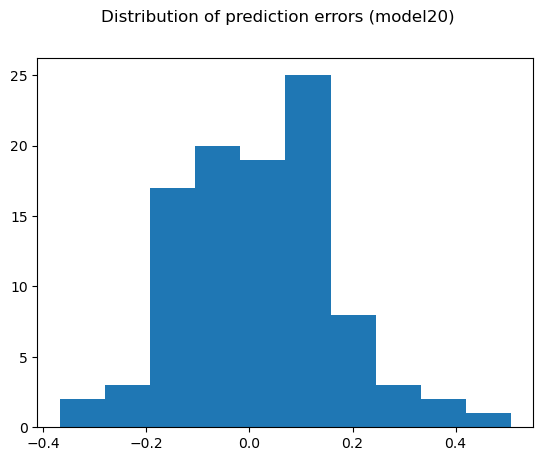

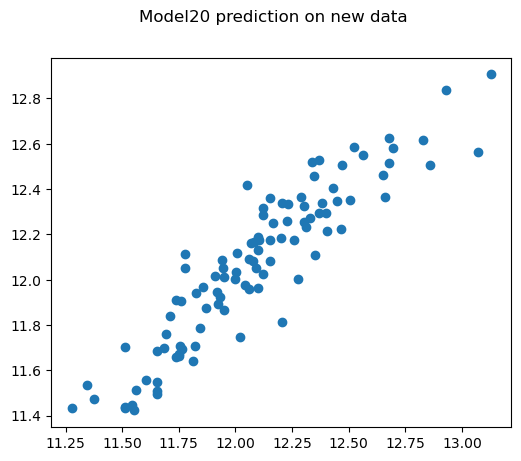

In [17]:
# Testing the models on the jtest dataset

# Keeping only the columns of interest for each model

# for model7
testX7 = jtest[['OverallQual', 'GrLivArea', 'GarageArea','YearBuilt','FullBath','MasVnrArea','TotRmsAbvGrd']]

# for model14
testX14 = jtest[['OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars',
       'YearBuilt', 'TotalBsmtSF', 'FullBath', 'MasVnrArea',
       'TotRmsAbvGrd', '1stFlrSF', 'YearRemodAdd', 'Fireplaces',
       'WoodDeckSF','2ndFlrSF']]

# for model20
testX20 = jtest[['OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars',
       'YearBuilt', 'TotalBsmtSF', 'FullBath', 'MasVnrArea',
       'TotRmsAbvGrd', '1stFlrSF', 'YearRemodAdd', 'Fireplaces',
       'WoodDeckSF','2ndFlrSF','BsmtUnfSF', 'HalfBath', 'OpenPorchSF', 'BsmtFinSF1',
       'YrSold', 'MoSold']]
 
# Optionally: taking the log of SalePrice, as we did in the fitting phase
testY = np.log(jtest['SalePrice'])
#testY = jtest['SalePrice']

predictions7 = model7.predict(testX7)
predictions14 = model14.predict(testX14)
predictions20 = model20.predict(testX20)

# distribution of prediction errors (to check that it looks normally distributed):
plt.hist(testY - model20.predict(testX20))
plt.suptitle('Distribution of prediction errors (model20)')

# Scatter plot of predictions: 
fig, axs = plt.subplots()
plt.scatter(testY, model20.predict(testX20))
plt.suptitle('Model20 prediction on new data')
axs.set_aspect('equal','box')

print(f'Shape of the jtest dataset: {jtest.shape}')
print(f'R-squared score of model7 (testing on new data): {model7.score(testX7, testY):.3f}')
print(f'R-squared score of model14 (testing on new data): {model14.score(testX14, testY):.3f}')
print(f'R-squared score of model20 (testing on new data): {model20.score(testX20, testY):.3f}')


We found the following.

With `SalePrice` (strictly linear model):
- R-squared score of model7 (testing on new data): 0.743
- R-squared score of model14 (testing on new data): 0.759
- R-squared score of model20 (testing on new data): 0.732

With `log(SalePrice)` (log-linear model):
- R-squared score of model7 (testing on new data): 0.788
- R-squared score of model14 (testing on new data): 0.836
- R-squared score of model20 (testing on new data): 0.843

**In summary, each of the 3 versions of the model performed noticeably better on `log(SalePrice)` than on `SalePrice`, confirming that a log-linear model is a better choice than a strictly linear model with these data.**

**Overall, the best fit was with the 20-variable log-linear model, which yielded $R^2 = 0.843$ when tested on new data.**

[Back to top](#Index)

## Conclusion

The highest performing model (out of the 6 models that we tested) was the log-linear model using 20 variables, which yielded a score of $R^2 = 0.843$ when tested on new data. Using fewer (14 or 7) variables lowered the performance (to $R^2 = 0.836$ and $0.788$, respectively). Of note, _not_ using the log-transformation on the target sale price data clearly lowered performance even further ($R^2 = 0.76$ and lower).

One important take-away from this project is the importance of checking underlying assumptions about the data, such as that it is normally distributed and symmetric, and to take appropriate measures in the data preparation phase (such as taking a log-transform to correct skewed data) as necessary.

A second point is that here we found that adding more explanatory variables (going from 7 to 14 to 20 independent variables) improved the fit. However, with many variables there is always a possibility of overfitting the model such that it predicts the training data very well but fails to generalize well to new data. In this particular dataset we may have been able to add even more variables and improve the fit further, or maybe it would have caused overfitting instead. Searching for the optimal number and choice of parameters would be an interesting next step.


[Back to top](#Index
)
## References

Scikit-Learn Linear Regression module for Python: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Ames Housing Dataset: https://www.kaggle.com/datasets/prevek18/ames-housing-dataset
